# SNIC

- Paper: https://openaccess.thecvf.com/content_cvpr_2017/papers/Achanta_Superpixels_and_Polygons_CVPR_2017_paper.pdf
- C implementation: https://github.com/achanta/SNIC

Possible to convert to CUDA? https://cuda-tutorial.readthedocs.io/en/latest/


In [1]:
!git clone https://github.com/achanta/SNIC.git

Cloning into 'SNIC'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 26 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (26/26), done.


In [2]:
%%bash
cd SNIC/snic_python_interface
python compile_snic_lib.py

generating ./_snic.c
the current directory is '/content/SNIC/snic_python_interface'
running build_ext
building '_snic' extension
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-dIfpci/python3.7-3.7.13=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-dIfpci/python3.7-3.7.13=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.7m -c _snic.c -o ./_snic.o -O3 -march=native -ffast-math
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-dIfpci/python3.7-3.7.13=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-dIfpci/python3.7-3.7.13=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.7m -c snic.c

In [3]:
import sys
sys.path.append('/content/SNIC/snic_python_interface')

In [4]:
import os
import subprocess
from PIL import Image
from skimage.io import imread,imshow
import numpy as np
from timeit import default_timer as timer
from _snic.lib import SNIC_main
from cffi import FFI

In [5]:
def segment(imgname,numsuperpixels,compactness,doRGBtoLAB):
	#--------------------------------------------------------------
	# read image and change image shape from (h,w,c) to (c,h,w)
	#--------------------------------------------------------------
	img = Image.open(imgname)
	# img = imread(imgname)
	img = np.asarray(img)
	print(img.shape)

	dims = img.shape
	h,w,c = dims[0],dims[1],1
	if len(dims) > 1:
		c = dims[2]
		img = img.transpose(2,0,1)
		print(c, "channels")
	
	#--------------------------------------------------------------
	# Reshape image to a single dimensional vector
	#--------------------------------------------------------------
	img = img.reshape(-1).astype(np.double)
	labels = np.zeros((h,w), dtype = np.int32)
	numlabels = np.zeros(1,dtype = np.int32)
	#--------------------------------------------------------------
	# Prepare the pointers to pass to the C function
	#--------------------------------------------------------------
	ffibuilder = FFI()
	pinp = ffibuilder.cast("double*", ffibuilder.from_buffer(img))
	plabels = ffibuilder.cast("int*", ffibuilder.from_buffer(labels.reshape(-1)))
	pnumlabels = ffibuilder.cast("int*", ffibuilder.from_buffer(numlabels))

	
	start = timer()
	SNIC_main(pinp,w,h,c,numsuperpixels,compactness,doRGBtoLAB,plabels,pnumlabels)
	end = timer()

	#--------------------------------------------------------------
	# Collect labels
	#--------------------------------------------------------------
	print("number of superpixels: ", numlabels[0])
	print("time taken in seconds: ", end-start)

	return labels.reshape(h,w),numlabels[0]


	# lib.SNICmain.argtypes = [np.ctypeslib.ndpointer(dtype=POINTER(c_double),ndim=2)]+[c_int]*4 +[c_double,c_bool,ctypes.data_as(POINTER(c_int)),ctypes.data_as(POINTER(c_int))]

def drawBoundaries(imgname,labels,numlabels):

	img = Image.open(imgname)
	# img = imread(imgname)
	img = np.array(img)
	print(img.shape)

	ht,wd = labels.shape

	for y in range(1,ht-1):
		for x in range(1,wd-1):
			if labels[y,x-1] != labels[y,x+1] or labels[y-1,x] != labels[y+1,x]:
				img[y,x,:] = 0

	return img


(425, 640, 3)
3 channels
number of superpixels:  504
time taken in seconds:  0.1609242819999963
(425, 640, 3)


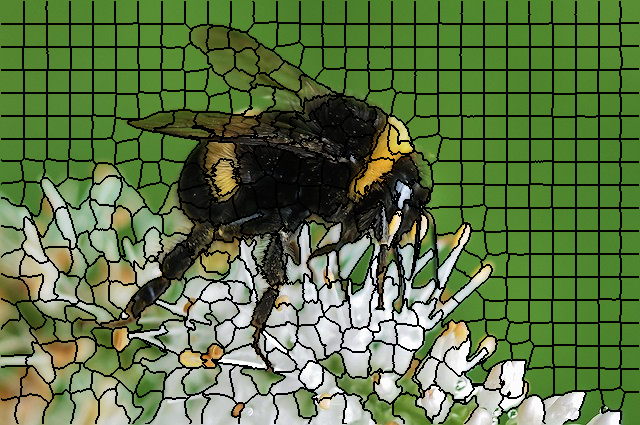

In [6]:
#--------------------------------------------------------------
# Set parameters and call the C function
#--------------------------------------------------------------
numsuperpixels = 500
compactness = 20.0
doRGBtoLAB = True # only works if it is a three channel image
# imgname = "/Users/achanta/Pictures/classics/lena.png"
imgname = "SNIC/snic_python_interface/bee.png"
labels,numlabels = segment(imgname,numsuperpixels,compactness,doRGBtoLAB)
#--------------------------------------------------------------
# Display segmentation result
#------------------------------------------------------------
segimg = drawBoundaries(imgname,labels,numlabels)
# Image.fromarray(segimg).show()
Image.fromarray(segimg)


In [7]:
!curl -O https://raw.githubusercontent.com/CSAILVision/ADE20K/main/dataset/ADE20K_2021_17_01/images/ADE/training/urban/street/ADE_train_00016869.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1079k  100 1079k    0     0  2079k      0 --:--:-- --:--:-- --:--:-- 2079k


In [8]:
numsuperpixels = 500
compactness = 20.0
doRGBtoLAB = True # only works if it is a three channel image
imgname = 'ADE_train_00016869.jpg'
labels,numlabels = segment(imgname,numsuperpixels,compactness,doRGBtoLAB)
segimg = drawBoundaries(imgname,labels,numlabels)
Image.fromarray(segimg)

Output hidden; open in https://colab.research.google.com to view.

In [9]:
import matplotlib.pyplot as plt

(483, 186, 3)
3 channels
number of superpixels:  198
time taken in seconds:  0.11331458600000133


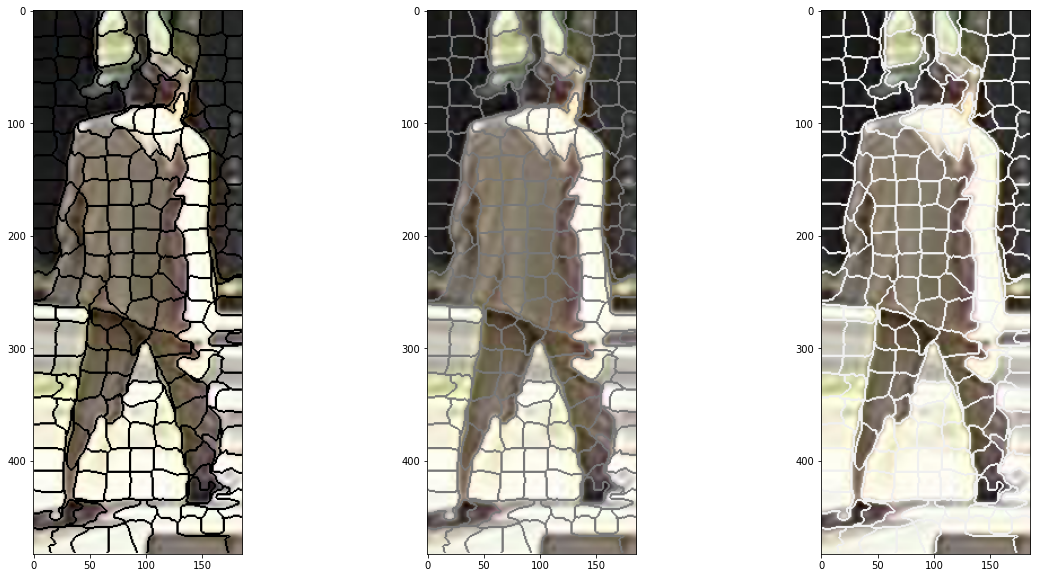

In [11]:
numsuperpixels = 200
compactness = 20.0
doRGBtoLAB = True # only works if it is a three channel image
imgname = 'ADE_train_00016869.jpg'
#labels,numlabels = segment(imgname,numsuperpixels,compactness,doRGBtoLAB)
#segimg = drawBoundaries(imgname,labels,numlabels)
#Image.fromarray(segimg)
                

img = Image.open(imgname)
img = np.asarray(img)
img = img[845:1006, 554:616, :]

img = Image.fromarray(img)
newsize = 3*np.asarray(img.size)
img = img.resize(newsize)
img = np.asarray(img)

img_box = img.copy()
print(img.shape)

dims = img.shape
h,w,c = dims[0],dims[1],1
if len(dims) > 1:
  c = dims[2]
  img = img.transpose(2,0,1)
  print(c, "channels")

#--------------------------------------------------------------
# Reshape image to a single dimensional vector
#--------------------------------------------------------------
img = img.reshape(-1).astype(np.double)
labels = np.zeros((h,w), dtype = np.int32)
numlabels = np.zeros(1,dtype = np.int32)

#--------------------------------------------------------------
# Prepare the pointers to pass to the C function
#--------------------------------------------------------------
ffibuilder = FFI()
pinp = ffibuilder.cast("double*", ffibuilder.from_buffer(img))
plabels = ffibuilder.cast("int*", ffibuilder.from_buffer(labels.reshape(-1)))
pnumlabels = ffibuilder.cast("int*", ffibuilder.from_buffer(numlabels))


start = timer()
SNIC_main(pinp,w,h,c,numsuperpixels,compactness,doRGBtoLAB,plabels,pnumlabels)
end = timer()

#--------------------------------------------------------------
# Collect labels
#--------------------------------------------------------------
print("number of superpixels: ", numlabels[0])
print("time taken in seconds: ", end-start)

labels, numlabels = labels.reshape(h,w), numlabels[0]

ht, wd = labels.shape

fig, ax = plt.subplots(1, 3, figsize=(20,10))
for color in [0, 120, 240]:
  im = img_box.copy()
  for y in range(1,ht-1):
    for x in range(1,wd-1):
      if labels[y,x-1] != labels[y,x+1] or labels[y-1,x] != labels[y+1,x]:
        im[y,x,:] = color

  ax[color//120].imshow(im)


# SLIC

- gSLICr report: https://arxiv.org/pdf/1509.04232.pdf
- gSLICr implementation: https://github.com/carlren/gSLICr
- With python wrapper: https://github.com/mikigom/gSLICrPy

Note: Too old. Build did not fail, but also it did not produce the module correctly.

In [ ]:
!git clone https://github.com/mikigom/gSLICrPy.git

Cloning into 'gSLICrPy'...
remote: Enumerating objects: 54, done.
remote: Total 54 (delta 0), reused 0 (delta 0), pack-reused 54
Unpacking objects: 100% (54/54), done.


In [ ]:
!cp gSLICrPy/CMakeLists.txt gSLICrPy/CMakeLists.txt.orig

In [ ]:
with open('gSLICrPy/CMakeLists.txt.orig', 'r') as file_in, open('gSLICrPy/CMakeLists.txt', 'w') as file_out:
  s = file_in.read()
  file_out.write(s.replace('compute_30', 'compute_75'))

In [ ]:
%%bash
cd gSLICrPy
mkdir build
cd build
cmake ../
makr

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Looking for pthread_create
-- Looking for pthread_create - not found
-- Looking for pthread_create in pthreads
-- Looking for pthread_create in pthreads - not found
-- Looking for pthread_create in pthread
-- Looking for pthread_create in pthread - found
-- Found Threads: TRUE  
-- Found CUDA: /usr/local/cuda (found version "11.1") 
-- Found O

/content/gSLICrPy/gSLICr_Lib/engines/gSLICr_seg_engine_GPU.cu(228): warning: dynamic initialization is not supported for a function-scope static __shared__ variable within a __device__/__global__ function

/content/gSLICrPy/gSLICr_Lib/engines/gSLICr_seg_engine_GPU.cu(229): warning: dynamic initialization is not supported for a function-scope static __shared__ variable within a __device__/__global__ function

/content/gSLICrPy/gSLICr_Lib/engines/gSLICr_core_engine.cpp:3:9: warning: #pragma once in main file
 #pragma once
         ^~~~
In file included from /content/gSLICrPy/gSLICr_Lib/engines/../gSLICr_defines.h:6:0,
                 from /content/gSLICrPy/gSLICr_Lib/engines/gSLICr_seg_engine.h:4,
                 from /content/gSLICrPy/gSLICr_Lib/engines/gSLICr_seg_engine_GPU.h:4,
                 from /content/gSLICrPy/gSLICr_Lib/engines/gSLICr_core_engine.h:4,
                 from /content/gSLICrPy/gSLICr_Lib/engines/gSLICr_core_engine.cpp:4:
/content/gSLICrPy/gSLICr_Lib/engines/../

In [ ]:
sys.path.append('/content/gSLICrPy')
sys.path.append('/content/gSLICrPy/build')

In [ ]:
from skimage.io import imread
#from gSLICrPy import __get_CUDA_gSLICr__, CUDA_gSLICr

In [ ]:
import gSLICrPy
dir(gSLICrPy)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [ ]:
image = imread('gSLICrPy/example.jpg')
img_size_y, img_size_x = image.shape[0:2]
image = image[:, :, ::-1].flatten().astype('uint8')

__CUDA_gSLICr__ = gSLICrPy.__get_CUDA_gSLICr__()

CUDA_gSLICr(__CUDA_gSLICr__,
            image,
            img_size_x=img_size_x,
            img_size_y=img_size_y,
            n_segs=10,
            spixel_size=20,
            coh_weight=0.6,
            n_iters=50,
            color_space=2,
            segment_color_space=2,
            segment_by_size=True,
            enforce_connectivity=True,
            out_name='example_results')

# cuda-slic

In [ ]:
!pip install cuda-slic

     |████████████████████████████████| 1.7 MB 11.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 68 kB 8.1 MB/s 
     |████████████████████████████████| 78 kB 8.6 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=626634 sha256=f2617d13ab552d60ff38f0e9cb71eadbd89a32514eb236869558147c4a9812bf
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2022.1.4-py2.py3-none-any.whl size=64565 sha256=837c4fdc4e3174cb96b33c70586643f049864c3e9444632b5cec0d0f29c7cdcf
  Stored in directory: /root/.cache/pip/wheels/3d/fa/11/780768f5d348db6336b7237aa800c324685d6fc792a7bfde55
Successfully built pycuda pytools


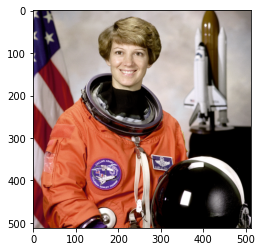

In [ ]:
from cuda_slic import slic
from skimage import data
import matplotlib.pyplot as plt

img = data.astronaut() 
plt.imshow(img)
plt.show()

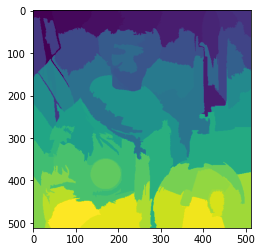

In [ ]:
# 2D RGB image
labels = slic(img, n_segments=100, compactness=5)
plt.imshow(labels)

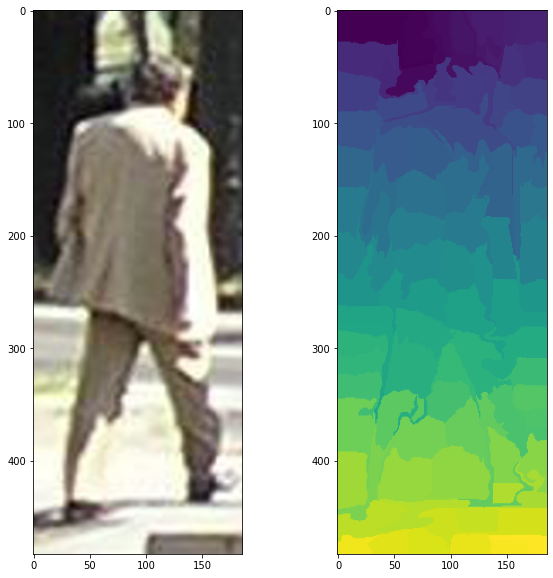

In [ ]:
from PIL import Image
import numpy as np
imgname = 'ADE_train_00016869.jpg'
img = Image.open(imgname)
img = np.asarray(img)
img = img[845:1006, 554:616, :]

img = Image.fromarray(img)
newsize = 3*np.asarray(img.size)
img = img.resize(newsize)
img = np.asarray(img)

labels = slic(img, n_segments=100, compactness=10)

fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(img)
ax[1].imshow(labels)

In [ ]:
# 3D gray scale
vol = data.binary_blobs(length=50, n_dim=3, seed=2)
labels = slic(vol, n_segments=100, multichannel=False, compactness=0.1)
print(vol.shape, labels.shape)
print(vol[10])
print(labels[10])

(50, 50, 50) (50, 50, 50)
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False  True False]
 ...
 [False False False ...  True  True False]
 [False False False ...  True  True False]
 [False  True False ...  True  True  True]]
[[ 3  3  3 ...  1  1  1]
 [ 3  3  3 ...  1  1  1]
 [ 3  3  3 ...  1  2  1]
 ...
 [ 9  9  9 ... 10 10 11]
 [ 9  9  9 ... 10 10 11]
 [ 9 13  9 ... 10 10 10]]


In [ ]:
# 3D multi-channel
# volume with dimensions (z, y, x, c)
# or video with dimensions (t, y, x, c)
vol = data.binary_blobs(length=33, n_dim=4, seed=2)
labels = slic(vol, n_segments=100, multichannel=True, compactness=1)

# scikit-image

In [ ]:
from skimage.segmentation import slic

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  """Entry point for launching an IPython kernel.


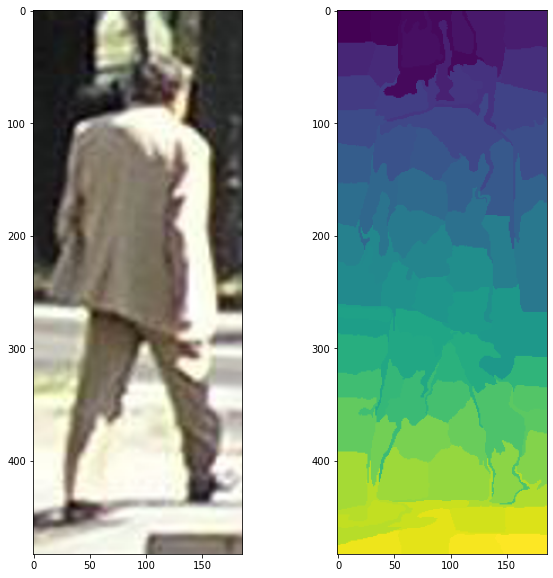

In [ ]:
segments = slic(img, n_segments=100, compactness=10)

fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(img)
ax[1].imshow(segments)

# OpenCV

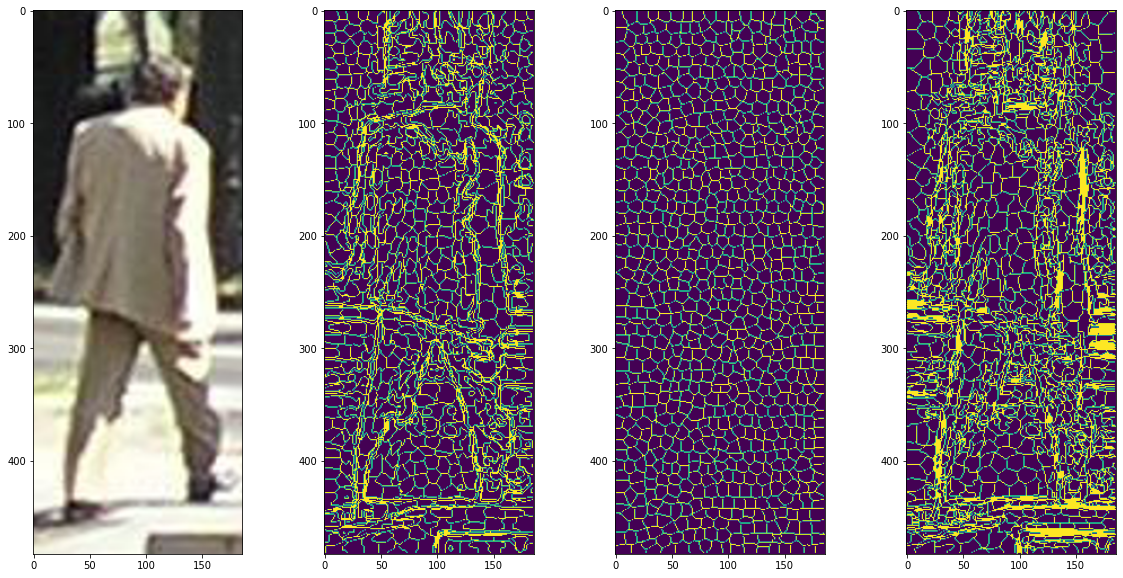

In [ ]:
import cv2.ximgproc as xip
from cv2.ximgproc import createSuperpixelSLIC

fig, ax = plt.subplots(1, 4, figsize=(20, 10))
ax[0].imshow(img)
sp = createSuperpixelSLIC(img, algorithm=xip.SLIC)
sp.iterate()
mask = sp.getLabelContourMask()
#mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
ax[1].imshow(mask)
sp = createSuperpixelSLIC(img, algorithm=xip.SLICO)
sp.iterate()
mask = sp.getLabelContourMask()
#mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
ax[2].imshow(mask)
sp = createSuperpixelSLIC(img, algorithm=xip.MSLIC)
sp.iterate()
mask = sp.getLabelContourMask()
#mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
ax[3].imshow(mask)